# IMO - Zadanie 3

Autorzy: Dariusz Max Adamski, Sławomir Gilewski

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import multiprocessing as mp
from time import time
from copy import deepcopy
plt.rc('figure', figsize=(9, 5))

In [2]:
def index(xs, e):
    try:
        return xs.index(e)
    except:
        return None
        
def find_node(cycles, a):
    i = index(cycles[0], a)
    if i is not None: return 0, i
    i = index(cycles[1], a)
    if i is not None: return 1, i
    print(cycles)
    assert False, f'City {a} must be in either cycle'
    
def remove_at(xs, sorted_indices):
    for i in reversed(sorted_indices):
        del(xs[i])

def reverse(xs, i, j):
    n = len(xs)
    d = (j - i) % n
    #print(d)
    for k in range(abs(d)//2+1):
        a, b = (i+k)%n, (i+d-k)%n
        #print(a, '<->', b)
        xs[a], xs[b] = xs[b], xs[a]

In [3]:
def distance(a, b):
    return np.round(np.sqrt(np.sum((a - b)**2)))

def read_instance(path):
    coords = pd.read_csv(path, sep=' ', names=['n','x','y'], skiprows=6, skipfooter=1, engine='python')
    cities = coords.drop(columns=['n']).values
    ns = np.arange(len(cities))
    cities = np.array([[distance(cities[i], cities[j]) for j in ns] for i in ns])
    return cities, coords

def draw_path(coords, path, color='blue'):
    cycle = path + [path[0]]
    for i in range(len(cycle) - 1):
        a, b = cycle[i], cycle[i+1]
        plt.plot([coords.x[a], coords.x[b]], [coords.y[a], coords.y[b]], color=color)

def plot_solution(coords, solution):
    path1, path2 = solution
    draw_path(coords, path1, color='green')
    draw_path(coords, path2, color='red')
    plt.scatter(coords.x, coords.y, color='black')
    
def cycle_score(cities, path):
    cycle = path + [path[0]]
    return sum(cities[cycle[i], cycle[i+1]] for i in range(len(cycle) - 1))

def score(cities, paths):
    return cycle_score(cities, paths[0]) + cycle_score(cities, paths[1])

In [4]:
def delta_insert(cities, path, i, city):
    a, b = path[i - 1], path[i]
    return cities[a, city] + cities[city, b] - cities[a, b]

def solve_regret(args):
    cities, start = args
    t0 = time()
    n = cities.shape[0]
    remaining = list(range(n))
    a, b = start, np.argmax(cities[start,:])
    remaining.remove(a)
    remaining.remove(b)
    paths = [[a], [b]]
    while remaining:
        for path in paths:
            scores = np.array([[delta_insert(cities, path, i, v) for i in range(len(path))] for v in remaining])
            best_city_idx = None
            if scores.shape[1] == 1:
                best_city_idx = np.argmin(scores)
            else:
                regret = np.diff(np.partition(scores, 1)[:,:2]).reshape(-1)
                weight = regret - 0.37*np.min(scores, axis=1)
                best_city_idx = np.argmax(weight)
                
            best_city = remaining[best_city_idx]
            best_insert = np.argmin(scores[best_city_idx])
            path.insert(best_insert, best_city)
            remaining.remove(best_city)
    return time() - t0, paths

def random_solution(n, seed=None):
    remaining = list(range(n))
    random.seed(seed)
    random.shuffle(remaining)
    return remaining[:n//2], remaining[n//2:]

In [5]:
def insert_move(moves, move):
    delta_x = move[0]
    for i, x in enumerate(moves):
        delta_y = x[0]
        if delta_x < delta_y:
            moves.insert(i, move)
            return
        elif delta_x == delta_y:
            return
    moves.append(move)

def has_edge(cycle, a, b):
    for i in range(len(cycle) - 1):
        x, y = cycle[i], cycle[i+1]
        if (a, b) == (x, y): return +1
        if (a, b) == (y, x): return -1
        
    x, y = cycle[-1], cycle[0]
    if (a, b) == (x, y): return +1
    if (a, b) == (y, x): return -1
    return 0

def any_has_edge(cycles, a, b):
    for i in range(2):
        status = has_edge(cycles[i], a, b)
        if status != 0: return i, status
    return None, 0

def delta_swap_node(D, x1, y1, z1, x2, y2, z2):
    return D[x1,y2] + D[z1,y2] - D[x1,y1] - D[z1,y1] + D[x2,y1] + D[z2,y1] - D[x2,y2] - D[z2,y2]

def make_swap_node(cities, cycles, cyc1, i, cyc2, j):
    C1, C2 = cycles[cyc1], cycles[cyc2]
    D = cities
    n, m = len(C1), len(C2)
    x1, y1, z1 = C1[(i-1)%n], C1[i], C1[(i+1)%n]
    x2, y2, z2 = C2[(j-1)%m], C2[j], C2[(j+1)%m]
    delta = delta_swap_node(cities, x1, y1, z1, x2, y2, z2)
    move = delta, SWAP_NODE, cyc1, cyc2, x1, y1, z1, x2, y2, z2
    return delta, move

def delta_swap_edge(cities, a, b, c, d):
    if a == d or a == b or a == c or b == c or b == d or c == d: return 1e8
    return cities[a, c] + cities[b, d] - cities[a, b] - cities[c, d]

def gen_swap_edge_2(cities, cycle, i, j):
    n = len(cycle)
    nodes = cycle[i], cycle[(i+1)%n], cycle[j], cycle[(j+1)%n]
    return (delta_swap_edge(cities, *nodes), *nodes)

def delta_swap_edge_2(cities, cycle, i, j):
    return gen_swap_edge_2(cities, cycle, i, j)[0]

def gen_swap_edge(n):
    return [(i, (i+d)%n) for i in range(n) for d in range(2, n-1)]

def gen_swap_node(n, m):
    return [(i, j) for i in range(n) for j in range(m)]


def init_moves(cities, cycles):
    moves = []
    for k in range(2):
        cycle = cycles[k]
        n = len(cycle)
        for i, j in gen_swap_edge(n):
            delta, a, b, c, d = gen_swap_edge_2(cities, cycle, i, j)
            if delta < 0: moves.append((delta, SWAP_EDGE, a, b, c, d))
    for i, j in gen_swap_node(len(cycles[0]), len(cycles[1])):
        delta, move = make_swap_node(cities, cycles, 0, i, 1, j)
        if delta < 0: moves.append(move)
    return moves
 
SWAP_EDGE, SWAP_NODE = range(2)
def apply_move(cycles, move):
    kind = move[1]
    if kind == SWAP_EDGE:
        _, _, a, _, c, _ = move
        (c1, i), (c2, j) = find_node(cycles, a), find_node(cycles, c)
        #print('swap edge', c1, i, c2, j, move[0])
        #assert c1 == c2, 'Cannot swap edges between cycles'
        cycle = cycles[c1]
        n = len(cycle)
        reverse(cycle, (i+1)%n, j)
    elif kind == SWAP_NODE:
        _, _, c1, c2, _, a, _, _, b, _ = move
        i, j = cycles[c1].index(a), cycles[c2].index(b)
        #print('swap node', c1, i, c2, j, move[0])
        #assert c1 != c2, 'Cannot swap nodes in the same cycle'
        cycles[c1][i], cycles[c2][j] = cycles[c2][j], cycles[c1][i]
    else:
        assert False, 'Invalid move type'

In [6]:
class SearchSteepest:
    def __init__(self, cities):
        self.cities = cities
    
    def __call__(self, cycles):
        cycles = deepcopy(cycles)
        start = time()
        while True:
            moves = init_moves(self.cities, cycles)
            if not moves: break
            move = min(moves, key=lambda x: x[0])
            apply_move(cycles, move)
        return time() - start, cycles

In [7]:
class SearchCandidates:
    def __init__(self, cities):
        self.cities = cities
    
    def __call__(self, cycles, k=10):
        N = len(self.cities)
        cycles = deepcopy(cycles)
        start = time()
        closest = np.argpartition(self.cities, k+1, axis=1)[:,:k+1]
        
        while True:
            best_move, best_delta = None, 0
            for a in range(N):
                for b in closest[a]:
                    if a == b: continue
                    (c1, i), (c2, j) = find_node(cycles, a), find_node(cycles, b)
                    move, delta = None, None
                    if c1 == c2:
                        cycle = cycles[c1]
                        n = len(cycle)
                        a, b, c, d = a, cycle[(i+1)%n], b, cycle[(j+1)%n]
                        delta = delta_swap_edge(self.cities, a, b, c, d)
                        move = delta, SWAP_EDGE, a, b, c, d
                    else:
                        delta, move = make_swap_node(self.cities, cycles, c1, i, c2, j)
                    if delta < best_delta:
                        best_delta, best_move = delta, move
                        
            if best_move is None:
                break
                
            apply_move(cycles, best_move)
                
        return time() - start, cycles

In [8]:
#%matplotlib notebook

class SearchMemory:
    def __init__(self, cities):
        self.cities = cities
    
    def next_moves(self, cycles, move):
        kind = move[1]
        moves = []
        if kind == SWAP_EDGE:
            _, _, a, b, c, d = move
            cycle = cycles[0] if a in cycles[0] else cycles[1]
            n = len(cycle)
            for i, j in gen_swap_edge(n):
                delta, a, b, c, d = gen_swap_edge_2(self.cities, cycle, i, j)
                if delta < 0: moves.append((delta, SWAP_EDGE, a, b, c, d))
                
        elif kind == SWAP_NODE:
            _, _, c1, c2, _, y1, _, _, y2, _ = move
            i, j = cycles[c1].index(y2), cycles[c2].index(y1)
            n, m = len(cycles[c1]), len(cycles[c2])
            for k in range(m):
                delta, move = make_swap_node(self.cities, cycles, c1, i, c2, k)
                if delta < 0: moves.append(move)
            for k in range(n):
                delta, move = make_swap_node(self.cities, cycles, c2, j, c1, k)
                if delta < 0: moves.append(move)
                
        #moves = init_moves(self.cities, cycles)
        return moves
    
    def __call__(self, cycles):
        cycles = deepcopy(cycles)
        start = time()
        moves = sorted(init_moves(self.cities, cycles), key=lambda x: x[0])
        #fig, ax = plt.subplots()
        
        while True:
            to_delete = []
            best_move = None
            for k, move in enumerate(moves):
                kind = move[1]
                if kind == SWAP_EDGE:
                    _, _, a, b, c, d = move
                    (c1, s1), (c2, s2) = any_has_edge(cycles, a, b), any_has_edge(cycles, c, d)
                    if c1 != c2 or s1 == 0 or s2 == 0:
                        to_delete.append(k)
                    elif s1 == s2 == +1:
                        to_delete.append(k)
                        best_move = move
                        break
                    elif s1 == s2 == -1:
                        to_delete.append(k)
                        best_move = move[0], SWAP_EDGE, b, a, d, c
                        break
                elif kind == SWAP_NODE:
                    _, _, c1, c2, x1, y1, z1, x2, y2, z2 = move
                    s1 = has_edge(cycles[c1], x1, y1)
                    s2 = has_edge(cycles[c1], y1, z1)
                    s3 = has_edge(cycles[c2], x2, y2)
                    s4 = has_edge(cycles[c2], y2, z2)
                    
                    if c1 == c2 or s1 == 0 or s2 == 0 or s3 == 0 or s4 == 0:
                        to_delete.append(k)
                    elif s1 == s2 and s3 == s4:
                        to_delete.append(k)
                        best_move = move
                        break
                    
            if best_move is None:
                break
                
            remove_at(moves, to_delete)
            apply_move(cycles, best_move)
            
            #plt.cla()
            #plot_solution(coords, cycles)
            #fig.canvas.draw()
            #plt.pause(0.001)
            
            new_moves = self.next_moves(cycles, best_move)
            moves = sorted(list(set(moves).union(set(new_moves))), key=lambda x: x[0])
            #print(len(moves))
            
        return time() - start, cycles
    
#cities, coords = read_instance('kroB200.tsp')
#sol = random_solution(200, seed=2020)
#t, sol = SearchMemory(cities)(sol)
#print(t)

file: kroA200.tsp, search: regret, score: 32631.0


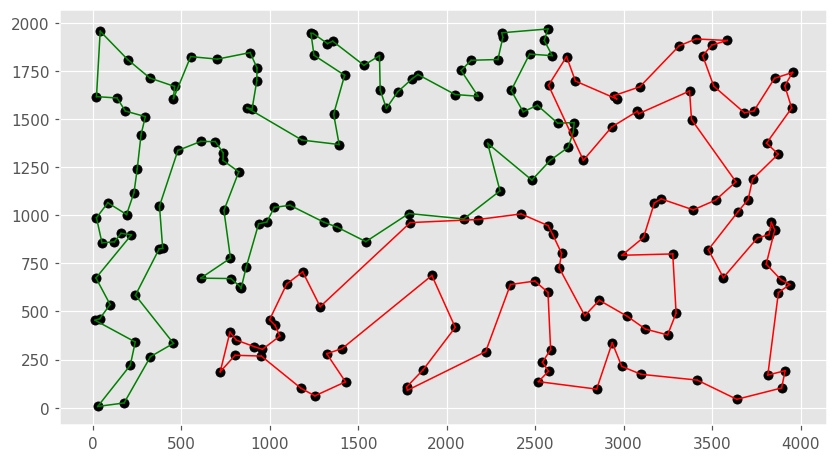

file: kroA200.tsp, search: SearchSteepest, score: 35152.0


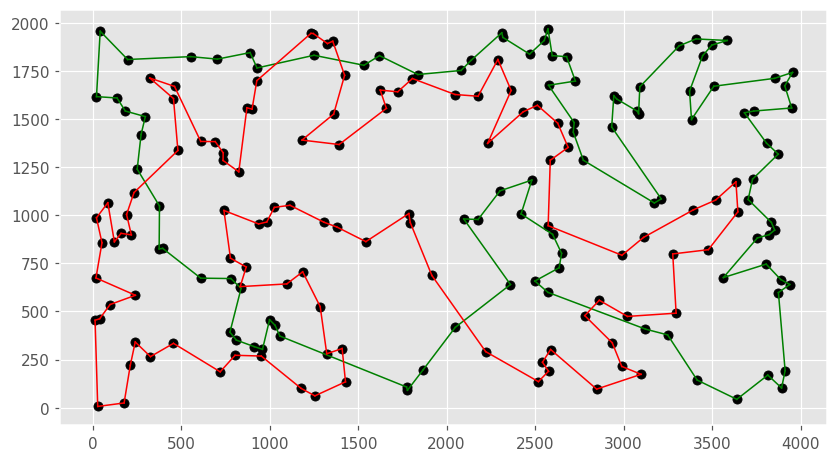

file: kroA200.tsp, search: SearchMemory, score: 43529.0


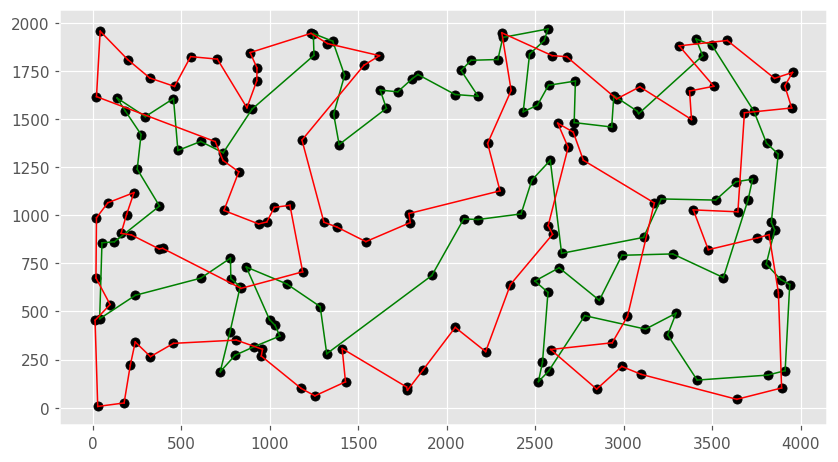

file: kroA200.tsp, search: SearchCandidates, score: 36882.0


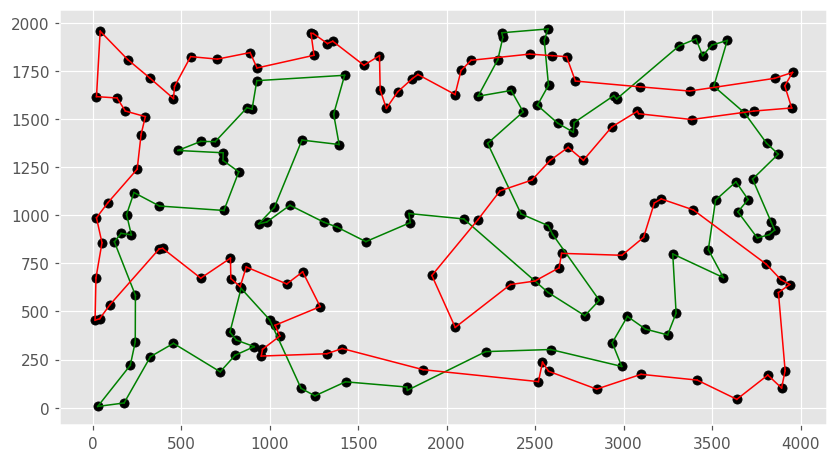

file: kroB200.tsp, search: regret, score: 32512.0


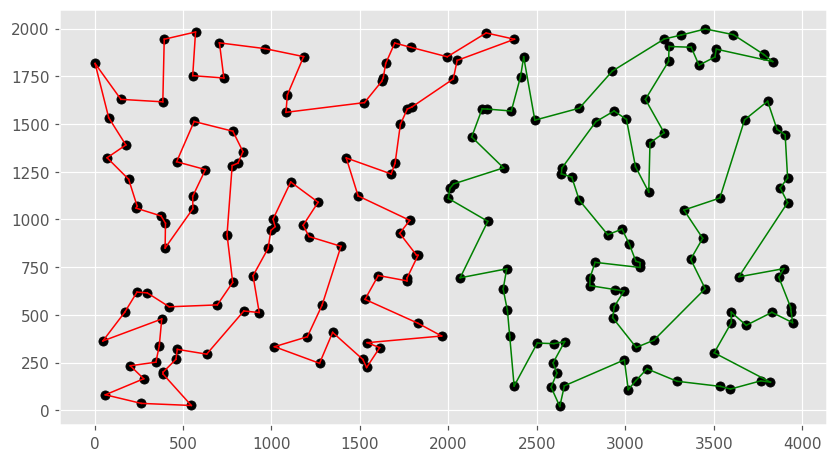

file: kroB200.tsp, search: SearchSteepest, score: 36422.0


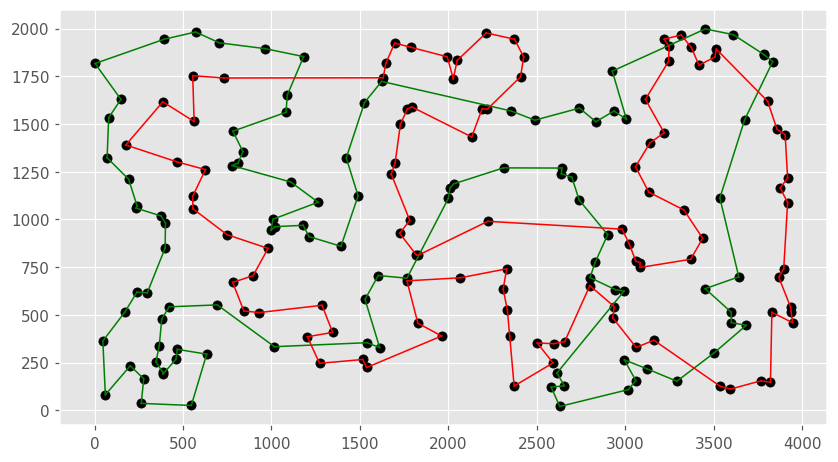

file: kroB200.tsp, search: SearchMemory, score: 43509.0


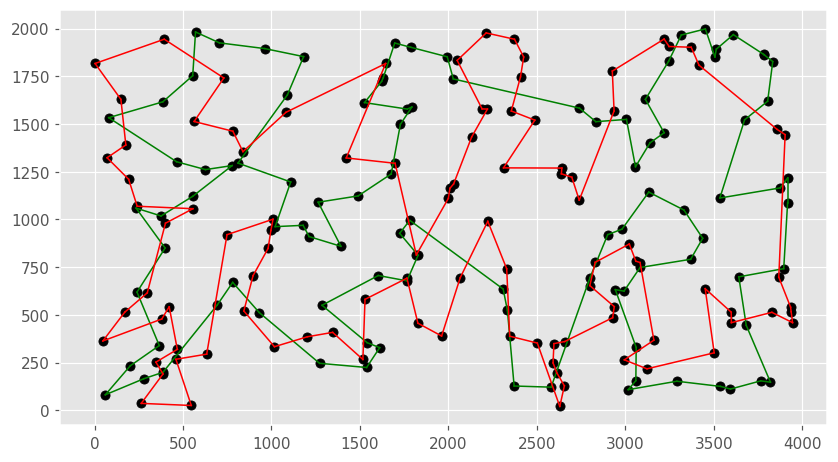

file: kroB200.tsp, search: SearchCandidates, score: 37853.0


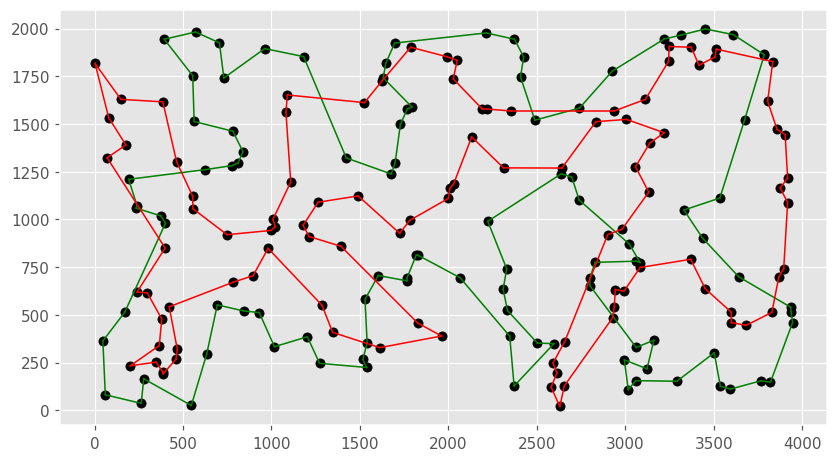

In [9]:
def compute_results():
    n = 200
    instances = [f'kroA{n}.tsp', f'kroB{n}.tsp']
    initial_solvers = [solve_regret]
    score_results = []
    time_results = []
    
    for file in instances:
        cities, coords = read_instance(file)
        solve = solve_regret
        times, init_solutions = zip(*mp.Pool().map(solve, [(cities, i) for i in range(n)]))
        scores = [score(cities, x) for x in init_solutions]
        
        score_results.append(dict(file=file, search="regret", min=int(min(scores)), mean=int(np.mean(scores)), max=int(max(scores))))
        time_results.append(dict(file=file, search="regret", min=float(min(times)), mean=float(np.mean(times)), max=float(max(times))))
        best_idx = np.argmin(scores)
        best = init_solutions[best_idx]
        print(f'file: {file}, search: regret, score: {scores[best_idx]}')
        plot_solution(coords, best)
        plt.show()
        
        for local_search in [SearchSteepest(cities), SearchMemory(cities), SearchCandidates(cities)]:
            rand_solutions = [random_solution(n) for _ in range(100)]
            times, solutions = zip(*mp.Pool().map(local_search, rand_solutions))
            #times, solutions = zip(*[local_search(x) for x in rand_solutions])
            scores = [score(cities, x) for x in solutions]
            best_idx = np.argmin(scores)
            best = solutions[best_idx]
            print(f'file: {file}, search: {type(local_search).__name__}, score: {scores[best_idx]}')
            plt.subplots()
            plot_solution(coords, best)
            plt.show()

            score_results.append(dict(file=file, search=type(local_search).__name__, min=int(min(scores)), mean=int(np.mean(scores)), max=int(max(scores))))
            time_results.append(dict(file=file, search=type(local_search).__name__, min=float(min(times)), mean=float(np.mean(times)), max=float(max(times))))
        
    return pd.DataFrame(score_results), pd.DataFrame(time_results)

scores, times = compute_results()

In [10]:
scores

,file,search,min,mean,max
0,kroA200.tsp,regret,32631,34790,38907
1,kroA200.tsp,SearchSteepest,35152,38749,42396
2,kroA200.tsp,SearchMemory,43529,45942,49333
3,kroA200.tsp,SearchCandidates,36882,39911,42560
4,kroB200.tsp,regret,32512,36299,38640
5,kroB200.tsp,SearchSteepest,36422,38554,41428
6,kroB200.tsp,SearchMemory,43509,45541,48482
7,kroB200.tsp,SearchCandidates,37853,39773,42433


In [11]:
times

,file,search,min,mean,max
0,kroA200.tsp,regret,0.346042,0.403103,0.591658
1,kroA200.tsp,SearchSteepest,9.583865,10.718405,12.048869
2,kroA200.tsp,SearchMemory,6.323468,7.761346,10.870667
3,kroA200.tsp,SearchCandidates,5.797556,6.506545,7.569556
4,kroB200.tsp,regret,0.343163,0.391453,0.634425
5,kroB200.tsp,SearchSteepest,9.699372,10.966508,13.316899
6,kroB200.tsp,SearchMemory,6.777590,7.999278,9.792198
7,kroB200.tsp,SearchCandidates,5.658702,6.484034,7.879067
